# Potato Disease Classification
### Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

## Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [11]:
#  68*32 = 2152 as we have 68 batchs each one has 68 images
# We have 32 images in each batch, each on eis 256*256 and 3 RGB channels
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 0 0 1 0 0 2 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1]


In [42]:
# We want to see the first image 
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())


[[[163. 165. 178.]
  [169. 171. 184.]
  [174. 176. 189.]
  ...
  [175. 177. 190.]
  [172. 174. 187.]
  [175. 177. 190.]]

 [[164. 166. 179.]
  [169. 171. 184.]
  [174. 176. 189.]
  ...
  [173. 175. 188.]
  [173. 175. 188.]
  [177. 179. 192.]]

 [[163. 165. 178.]
  [167. 169. 182.]
  [172. 174. 187.]
  ...
  [172. 174. 187.]
  [173. 175. 188.]
  [176. 178. 191.]]

 ...

 [[128. 126. 139.]
  [132. 130. 143.]
  [139. 137. 150.]
  ...
  [139. 137. 150.]
  [159. 157. 170.]
  [160. 158. 171.]]

 [[136. 134. 147.]
  [132. 130. 143.]
  [135. 133. 146.]
  ...
  [129. 127. 140.]
  [139. 137. 150.]
  [144. 142. 155.]]

 [[139. 137. 150.]
  [130. 128. 141.]
  [131. 129. 142.]
  ...
  [161. 159. 172.]
  [137. 135. 148.]
  [148. 146. 159.]]]


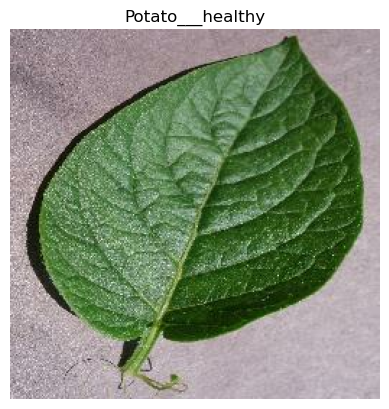

In [94]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")
    

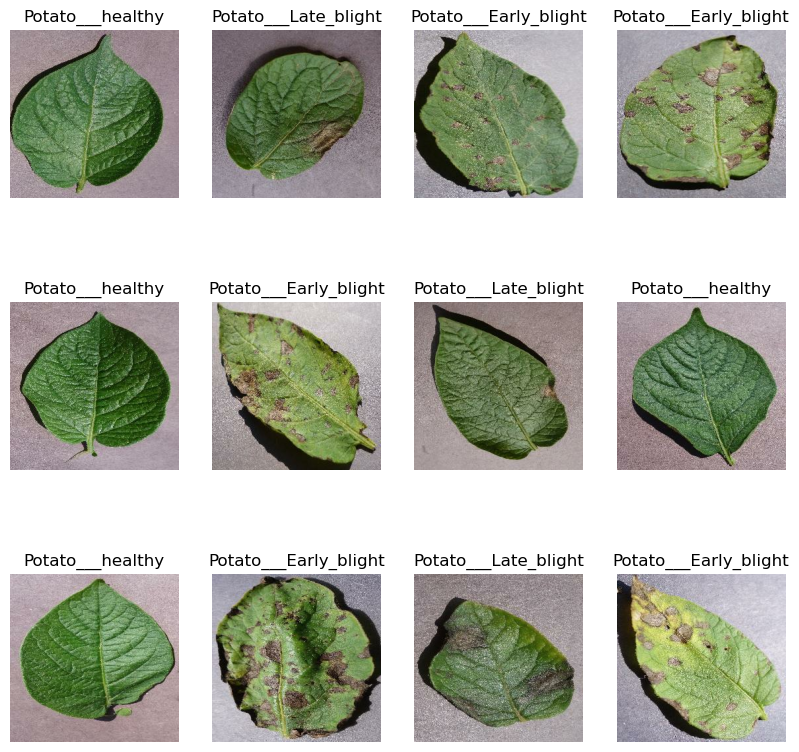

In [102]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training 
20% ==> 10% validation, 10% test 

In [104]:
train_size = 0.8
train_ds_len = len(dataset)*train_size
train_ds = dataset.take(int(train_ds_len))
len(train_ds)

54

In [115]:
test_ds = dataset.skip(int(train_ds_len))
len(test_ds)

14

In [116]:
val_ds = test_ds.take(int(len(dataset)*0.1))
len(val_ds)

6

In [117]:
test_ds = test_ds.skip(len(val_ds))
len(test_ds)

8

## Split the Dataset

In [118]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [119]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [120]:
len(train_ds)

54

In [121]:
len(val_ds)

6

In [123]:
len(test_ds)

8

## Cache, Shuffle, and Prefetch the Dataset

In [129]:
# Caching a prefetching concept, improves th eperformance of the pipeline ( It will read an image from the disk and for the next iteration when you need the image you will find it stored in th memory 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Building the Model
## Creating a Layer for Resizing and Normalization
1. Resize the images to the desired size.
2. To improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).it

In [134]:
# keeping images in range 0 and 1 by dividing by 256, resizing the ones with size =/= 256*256
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

## Data Augmentation
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the number of images

In [135]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [136]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
### We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [137]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

E:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [139]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
### We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [140]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [141]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.4741 - loss: 0.9456 - val_accuracy: 0.4844 - val_loss: 0.8520
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.6591 - loss: 0.6820 - val_accuracy: 0.8333 - val_loss: 0.4200
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 437ms/step - accuracy: 0.7714 - loss: 0.5113 - val_accuracy: 0.8698 - val_loss: 0.3135
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 438ms/step - accuracy: 0.7820 - loss: 0.5277 - val_accuracy: 0.8750 - val_loss: 0.3009
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.8763 - loss: 0.3105 - val_accuracy: 0.8750 - val_loss: 0.2739
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 406ms/step - accuracy: 0.9051 - loss: 0.2458 - val_accuracy: 0.8594 - val_loss: 0.2980
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 405ms/step - accuracy: 0.9295 - loss: 0.2063 - val_accuracy: 0.8594 - val_loss: 0.3163
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.9264 - loss: 0.2051 - val_accu

In [142]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9759 - loss: 0.1039


In [143]:
scores

[0.07015252858400345, 0.98046875]

In [144]:
history

In [145]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [146]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [149]:
history.history['accuracy']

[0.49189814925193787,
 0.734375,
 0.7934027910232544,
 0.8026620149612427,
 0.8778935074806213,
 0.8975694179534912,
 0.9212962985038757,
 0.9120370149612427,
 0.9392361044883728,
 0.9265046119689941,
 0.9340277910232544,
 0.9600694179534912,
 0.9583333134651184,
 0.9508101940155029,
 0.9716435074806213,
 0.9577546119689941,
 0.9594907164573669,
 0.9780092835426331,
 0.9681712985038757,
 0.96875,
 0.9756944179534912,
 0.9652777910232544,
 0.9780092835426331,
 0.9861111044883728,
 0.9878472089767456,
 0.9791666865348816,
 0.984375,
 0.9866898059844971,
 0.9780092835426331,
 0.9704861044883728,
 0.9832175970077515,
 0.9895833134651184,
 0.9895833134651184,
 0.9832175970077515,
 0.9901620149612427,
 0.9895833134651184,
 0.9722222089767456,
 0.9878472089767456,
 0.9884259104728699,
 0.9809027910232544,
 0.9924768805503845,
 0.9936342835426331,
 0.9913194179534912,
 0.9884259104728699,
 0.9947916865348816,
 0.9936342835426331,
 0.9947916865348816,
 0.9878472089767456,
 0.9768518805503845,
 

## Plotting Accuracy and Loss Curves

In [150]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

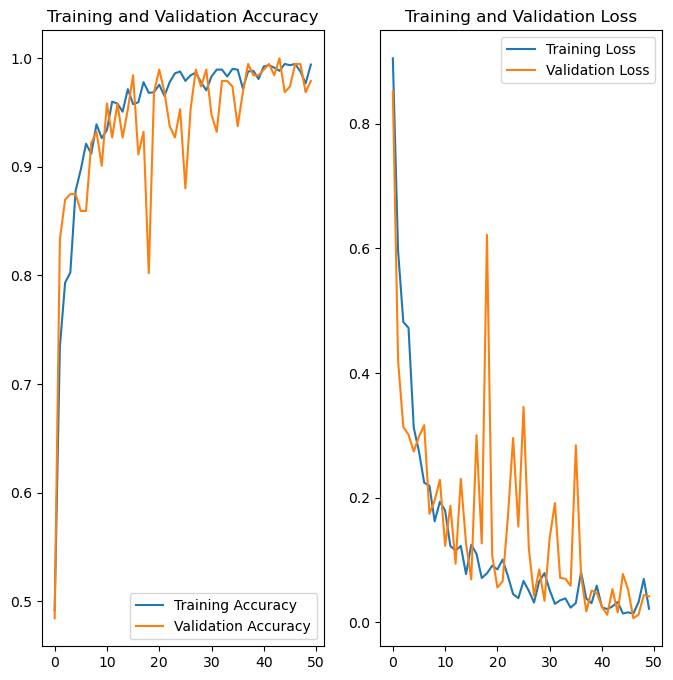

In [151]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
predicted label: Potato___Early_blight


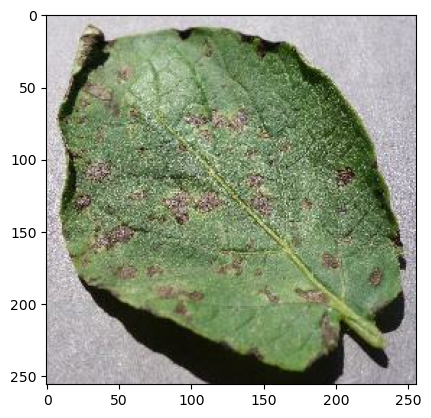

In [228]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## A function for inference

In [230]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


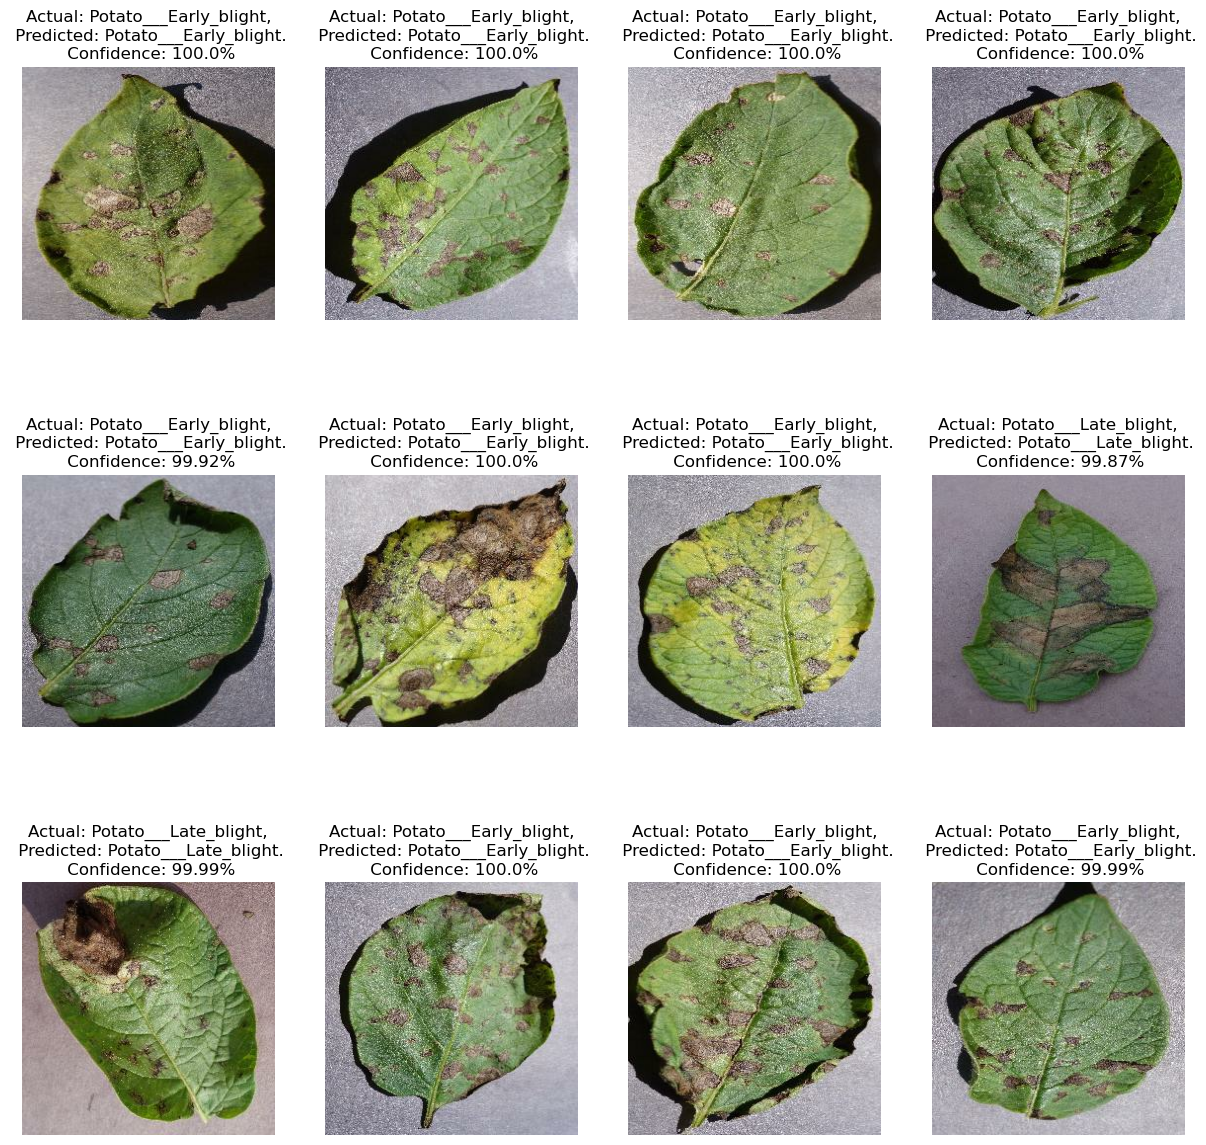

In [234]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [254]:
import os
model_version = max([int(i) for i in os.listdir("models") if i.isdigit()] + [0]) + 1
model.save(f"models/{model_version}.keras")  # Use the `.keras` extension for saving

In [258]:
model.save("models/potatoes.h5")